# Introduction
Author : Laroussi Labid Bachri



Ce notebook montre comment exécuter des requêtes SQL et exploiter les résultats avec pandas pour l'analyse de données. Il a été conçu pour être inclus dans un dépôt GitHub et sert de guide reproductible pour :
- se connecter à une base de données (SQLite) sans exposer de credentials,
- exécuter des requêtes SQL (sélection, jointures, agrégations),
- charger et transformer les résultats dans des pandas.DataFrame,
- effectuer des opérations de nettoyage, d'analyse et d'export (CSV/parquet).

Prérequis
- Python 3.8+
- pandas, sqlite3
- variables d'environnement ou fichier .env pour la string de connexion (ne pas committer les credentials)




## Sommaire
- [Vue d'ensemble des ventes](#vue)
- [Analyse des produits](#produits)
- [Analyse géographique](#geo)
- [Analyse temporelle](#temps)
- [Analyse clients](#clients)
- [Indicateurs clé](#indicateurs)
- [Utilisation de pandas](#pandas)
- [Visualisation de pandas](#visualisation)




<p style="font-size:30px; color:#2F5D75; font-weight:bold;">Importation des modules necessaires</p>

In [18]:
import pandas as pd
import sqlite3
import numpy as np
from pprint import pprint
import matplotlib.pyplot as plt


<p style="font-size:30px; color:#2F5D75; font-weight:bold;">Connexion a la base de données (local)</p>

In [19]:
con = sqlite3.connect('../main.db')
cur = con.cursor()

In [20]:
cur.execute('Select orderID FROM ventes') # execute ne renvoie rien tout seul faut utiliser fetchall et print
orders = [r[0] for r in cur.fetchall()] # on ameliore la lisbilite avec une liste au lieu d'une liste de tuples.
pprint(orders[:5])

[10100, 10100, 10100, 10100, 10101]


<p style="font-size:38px; color:#CAD9B2; font-weight:bold;">Utilisation de SQLite3</p>


<p style="font-size:30px; color:#2F5D75; font-weight:bold;">Qualité des données</p>




<h2 style="color:#93B336; font-size:22px;">Données incohérentes</h2>
<p>Vérification des prix ou quantités nulles ou négatives.</p>

In [21]:
cur.execute('''SELECT *
FROM ventes
WHERE price <= 0 OR quantity <= 0;''')

nan_prices_quantity = cur.fetchall()




<h2 style="color:#93B336; font-size:22px;">Valeurs manquantes</h2>
<p>Détection des champs critiques vides pour garantir l’intégrité de l’analyse.</p>

In [22]:
cur.execute('''SELECT *
FROM ventes
WHERE orderID IS NULL OR company_name IS NULL OR sales IS NULL;''') 

nan = cur.fetchall()
if len(nan)== 0 and len(nan_prices_quantity)==0:
    print('Les données sont propres. Nous pouvons alors les analyser. ')



Les données sont propres. Nous pouvons alors les analyser. 


<h1 id="vue" style="font-size:30px; color:#2F5D75; font-weight:bold;">
 Vue d'ensemble des ventes
</h1>



<h2 style="color:#93B336; font-size:22px;">Chiffre d'affaires total</h2>
<p>Analyse du chiffre d'affaires global sur toute la période étudiée.</p>

In [23]:
cur.execute('SELECT ROUND(SUM(sales),2) as total_sales FROM ventes')
ca = cur.fetchone()[0]
print(f"Le chiffre d'affaire totale est de {ca} €")

Le chiffre d'affaire totale est de 10032628.85 €


<h2 style="color:#93B336; font-size:22px;">Nombre total de commandes</h2>
<p>Nombre de commandes passées, avec analyse de leur répartition par année.</p>

In [24]:
cur.execute('SELECT COUNT(DISTINCT orderID) as total_orders FROM ventes')
total_orders = cur.fetchone()[0]
print(f"Le nombre total de commandes est de {total_orders}")

Le nombre total de commandes est de 307


<h2 style="color:#93B336; font-size:22px;">Nombre de clients distincts</h2>
<p>Comptage des clients uniques pour estimer la diversité du portefeuille client.</p>

In [25]:
cur.execute('SELECT COUNT(DISTINCT company_name) as total_clients FROM ventes')
total_clients= cur.fetchone()[0]
print(f"Le nombre total de clients est de {total_clients}")

Le nombre total de clients est de 92


<h1 id="produits" style="font-size:30px; color:#2F5D75; font-weight:bold;">
Analyse des produits
</h1>

<h2 style="color:#93B336; font-size:22px;"> Top 10 des produits les plus vendus</h2>
<p>Liste des références produits générant le plus de chiffre d'affaires.</p>

In [26]:
cur.execute('''SELECT ref_prod, product_category, ROUND(SUM(sales), 2) AS total_sales FROM ventes
GROUP BY ref_prod, product_category
ORDER BY total_sales DESC
LIMIT 10;''')
top10_prod = cur.fetchall()
print(f"Le top 10 des produits les plus vendus :\n")
for i, (code, category, total) in enumerate(top10_prod, start=1):
    print(f"{i:>2}. {code:<10} | {category:<15} | {total:>10,.2f} €")

Le top 10 des produits les plus vendus :

 1. S18_3232   | Classic Cars    | 288,245.42 €
 2. S10_1949   | Classic Cars    | 191,073.03 €
 3. S10_4698   | Motorcycles     | 170,401.07 €
 4. S12_1108   | Classic Cars    | 168,585.32 €
 5. S18_2238   | Classic Cars    | 154,623.95 €
 6. S12_3891   | Classic Cars    | 145,332.04 €
 7. S24_3856   | Classic Cars    | 140,626.90 €
 8. S12_2823   | Motorcycles     | 140,006.16 €
 9. S18_1662   | Planes          | 139,421.97 €
10. S12_1099   | Classic Cars    | 137,177.01 €


<h2 style="color:#93B336; font-size:22px;">Analyse par catégorie de produits</h2>
<p>Comparaison du chiffre d'affaires entre les différentes categories (Classic Cars, Motorcycles, etc.).</p>

In [27]:
cur.execute('''SELECT product_category, ROUND(SUM(sales), 2) AS total_sales
FROM ventes
GROUP BY product_category
ORDER BY total_sales DESC
LIMIT 5
;''')

top5_category = cur.fetchall()
for i, ( category, total) in enumerate(top5_category, start=1):
    print(f"{category:<15} | {total:>10,.2f} €")

Classic Cars    | 3,919,615.66 €
Vintage Cars    | 1,903,150.84 €
Motorcycles     | 1,166,388.34 €
Trucks and Buses | 1,127,789.84 €
Planes          | 975,003.57 €


<h1 id="geo" style="font-size:30px; color:#2F5D75; font-weight:bold;">
Analyse géographique
</h1>


<h2 style="color:#93B336; font-size:22px;">Classement des pays par chiffre d'affaires</h2>
<p>Identification des marchés les plus performants en termes de ventes.</p>

In [28]:
cur.execute('''SELECT country, ROUND(SUM(sales), 2) AS total_sales
FROM ventes
GROUP BY country
ORDER BY total_sales DESC
LIMIT 10;
''')

top10countries = cur.fetchall()
for i, (country, total) in enumerate(top10countries, start=1):
    print(f"{country:<15} | {total:>10,.2f} €")

USA             | 3,627,982.83 €
Spain           | 1,215,686.92 €
France          | 1,110,916.52 €
Australia       | 630,623.10 €
UK              | 478,880.46 €
Italy           | 374,674.31 €
Finland         | 329,581.91 €
Norway          | 307,463.70 €
Singapore       | 288,488.41 €
Denmark         | 245,637.15 €


Les 3 pays avec un plus grand chiffre d'affaire sont les Etats Unis, la France et l'Espagne.


<h2 style="color:#93B336; font-size:22px;">
Moyenne des ventes par pays</h2>
<p>Étude comparative du panier moyen selon la localisation géographique.</p>

In [29]:
cur.execute('''SELECT country, ROUND(AVG(sales), 2) AS avg_sales
FROM ventes
GROUP BY country
ORDER BY avg_sales DESC
;
''')

moy_countries = cur.fetchall()
for i, (country, avg_sales) in enumerate(moy_countries, start=1):
    print(f"{country:<15} | {avg_sales:>10,.2f} €")


Denmark         |   3,899.00 €
Switzerland     |   3,797.21 €
Sweden          |   3,684.46 €
Austria         |   3,673.86 €
Singapore       |   3,651.75 €
Japan           |   3,618.61 €
Norway          |   3,617.22 €
Philippines     |   3,615.99 €
USA             |   3,613.53 €
Ireland         |   3,609.78 €
Finland         |   3,582.41 €
Germany         |   3,556.00 €
Spain           |   3,554.64 €
France          |   3,537.95 €
Australia       |   3,408.77 €
UK              |   3,325.56 €
Italy           |   3,315.70 €
Belgium         |   3,285.23 €
Canada          |   3,201.12 €


On obtient ici la moyenne de ventes par commande selon les pays.

<h1 id="temps" style="font-size:30px; color:#2F5D75; font-weight:bold;">
Analyse temporelle
</h1>

<h2 style="color:#93B336; font-size:22px;">Évolution du chiffre d'affaires par année</h2>
<p>Suivi de la croissance ou de la baisse des ventes sur plusieurs exercices.</p>

In [30]:
cur.execute('''SELECT year, ROUND(SUM(sales), 2) AS total_sales
FROM ventes
GROUP BY year
ORDER BY year;
''')

evol_ca_annee = cur.fetchall()

print("Évolution du chiffre d'affaires par année:\n")
for year , sales in evol_ca_annee:
    print(f"{year:<10} | {sales:>12,.2f} €")


Évolution du chiffre d'affaires par année:

2003       | 3,516,979.54 €
2004       | 4,724,162.60 €
2005       | 1,791,486.71 €


<h2 style="color:#93B336; font-size:22px;">Répartition par trimestre</h2>
<p>Visualisation des cycles de ventes saisonniers ou des pics d’activité trimestriels.</p>

In [31]:
cur.execute('''
SELECT year, QTR_ID AS quarter, ROUND(SUM(sales), 2) AS total_sales
FROM ventes
GROUP BY year, quarter
ORDER BY year, quarter;
''')

evol_ca_trim = cur.fetchall()

print("Évolution du chiffre d'affaires par trimestre:\n")
for year, quarter, sales in evol_ca_trim:
    print(f"{year:<6} | T{quarter:<2} | {sales:>12,.2f} €")


Évolution du chiffre d'affaires par trimestre:

2003   | T1  |   445,094.69 €
2003   | T2  |   562,365.22 €
2003   | T3  |   649,514.54 €
2003   | T4  | 1,860,005.09 €
2004   | T1  |   833,730.68 €
2004   | T2  |   766,260.73 €
2004   | T3  | 1,109,396.27 €
2004   | T4  | 2,014,774.92 €
2005   | T1  | 1,071,992.36 €
2005   | T2  |   719,494.35 €


<h2 style="color:#93B336; font-size:22px;">
Évolution mensuelle</h2>
<p>Analyse plus fine des tendances de ventes au fil des mois.</p>

In [32]:
cur.execute('''
SELECT year, month, ROUND(SUM(sales), 2) AS total_sales
FROM ventes
GROUP BY year, month
ORDER BY year, month;
''')

evol_ca_mois = cur.fetchall()

print("\nÉvolution du chiffre d'affaires par mois:\n")
for year, month, sales in evol_ca_mois:
    print(f"{year:<6} | Mois {month:<2} | {sales:>12,.2f} €")



Évolution du chiffre d'affaires par mois:

2003   | Mois 1  |   129,753.60 €
2003   | Mois 2  |   140,836.19 €
2003   | Mois 3  |   174,504.90 €
2003   | Mois 4  |   201,609.55 €
2003   | Mois 5  |   192,673.11 €
2003   | Mois 6  |   168,082.56 €
2003   | Mois 7  |   187,731.88 €
2003   | Mois 8  |   197,809.30 €
2003   | Mois 9  |   263,973.36 €
2003   | Mois 10 |   568,290.97 €
2003   | Mois 11 | 1,029,837.66 €
2003   | Mois 12 |   261,876.46 €
2004   | Mois 1  |   316,577.42 €
2004   | Mois 2  |   311,419.53 €
2004   | Mois 3  |   205,733.73 €
2004   | Mois 4  |   206,148.12 €
2004   | Mois 5  |   273,438.39 €
2004   | Mois 6  |   286,674.22 €
2004   | Mois 7  |   327,144.09 €
2004   | Mois 8  |   461,501.27 €
2004   | Mois 9  |   320,750.91 €
2004   | Mois 10 |   552,924.25 €
2004   | Mois 11 | 1,089,048.01 €
2004   | Mois 12 |   372,802.66 €
2005   | Mois 1  |   339,543.42 €
2005   | Mois 2  |   358,186.18 €
2005   | Mois 3  |   374,262.76 €
2005   | Mois 4  |   261,633.29 €
2005


<h1 id="clients" style="font-size:30px; color:#2F5D75; font-weight:bold;">
Analyse clients
</h1>

<h2 style="color:#93B336; font-size:22px;">Top 10 des meilleurs clients</h2>
<p>Clients les plus rentables sur la période étudiée.</p>

In [33]:
cur.execute('''SELECT company_name, ROUND(SUM(sales), 2) AS total_sales
FROM ventes
GROUP BY company_name
ORDER BY total_sales DESC
LIMIT 10;
''')

top10clients = cur.fetchall()

for i , (company_name , total_sales) in enumerate(top10clients,start=1):
    print(f"{company_name:<10} | {total_sales:>12,.2f} €")



Euro Shopping Channel |   912,294.11 €
Mini Gifts Distributors Ltd. |   654,858.06 €
Australian Collectors, Co. |   200,995.41 €
Muscle Machine Inc |   197,736.94 €
La Rochelle Gifts |   180,124.90 €
Dragon Souveniers, Ltd. |   172,989.68 €
Land of Toys Inc. |   164,069.44 €
The Sharp Gifts Warehouse |   160,010.27 €
AV Stores, Co. |   157,807.81 €
Anna's Decorations, Ltd |   153,996.13 €


<h2 style="color:#93B336; font-size:22px;">Taille moyenne des commandes</h2>
<p>Analyse du montant moyen par commande et par taille de deal.</p>


In [34]:
cur.execute('''SELECT taille, ROUND(AVG(sales), 2) AS avg_sales
FROM ventes
GROUP BY taille
ORDER BY avg_sales DESC;
''')

taille_moy_commandes = cur.fetchall()

for i , (taille , avg_sales) in enumerate(taille_moy_commandes,start=1):
    print(f"{taille:<10} | {avg_sales:>12,.2f} €")



Large      |     8,293.75 €
Medium     |     4,398.43 €
Small      |     2,061.68 €



<h1 id="indicateurs" style="font-size:30px; color:#2F5D75; font-weight:bold;">
Indicateurs clé
</h1>


<h2 style="color:#93B336; font-size:22px;">Ticket moyen</h2>
<p>Montant moyen du chiffre d'affaires par commande.</p>

In [35]:
cur.execute('''SELECT ROUND(SUM(sales) / COUNT(DISTINCT orderID), 2) AS avg_ticket
FROM ventes;
''')

avg_ticket = cur.fetchall()[0]

for i , (avg_ticket) in enumerate(avg_ticket,start=1):
    print(f"Le ticket moyen est de {avg_ticket:,.2f} € par commande.")

Le ticket moyen est de 32,679.57 € par commande.


<h2 style="color:#93B336; font-size:22px;">Produits par commande</h2>
<p>Nombre moyen de lignes produits par commande, indicateur d’upselling.</p>

In [36]:
cur.execute('''SELECT ROUND(COUNT(*) * 1.0 / COUNT(DISTINCT orderID), 2) AS avg_products_per_order
FROM ventes;
''')

avg_products_per_order = cur.fetchall()[0]

for i , (avg_products_per_order) in enumerate(avg_products_per_order,start=1):
    print(f"Le nombre de produits moyen est de {avg_products_per_order:,.2f} par commande.")


Le nombre de produits moyen est de 9.20 par commande.



<h1 id="pandas" style="font-size:30px; color:#2F5D75; font-weight:bold;">
Utilisation de pandas 🐼
</h1>

La premiere chose que l'on va faire est de charger notre table sous forme de dataframe pour pouvoir manipuler les données avec pandas.


In [37]:
con = sqlite3.connect("../main.db")
df = pd.read_sql_query('SELECT * FROM ventes',con)

In [38]:
df.head()

,orderID,orderlinenumber,quantity,price,sales,date,status,QTR_ID,month,year,...,adress,adress_comp,city,state,zipcode,country,territory,contact_last_name,contact_first_name,taille
0,10107,2,30,95.70,2871.00,2/24/2003 0:00,Shipped,1,2,2003,...,897 Long Airport Avenue,,NYC,NY,10022,USA,NA,Yu,Kwai,Small
1,10121,5,34,81.35,2765.90,5/7/2003 00:00,Shipped,2,5,2003,...,59 rue de l'Abbaye,,Reims,,51100,France,EMEA,Henriot,Paul,Small
2,10134,2,41,94.74,3884.34,7/1/2003 00:00,Shipped,3,7,2003,...,27 rue du Colonel Pierre Avia,,Paris,,75508,France,EMEA,Da Cunha,Daniel,Medium
3,10145,6,45,83.26,3746.70,8/25/2003 0:00,Shipped,3,8,2003,...,78934 Hillside Dr.,,Pasadena,CA,90003,USA,NA,Young,Julie,Medium
4,10159,14,49,100.00,5205.27,10/10/2003 00:00,Shipped,4,10,2003,...,7734 Strong St.,,San Francisco,CA,,USA,NA,Brown,Julie,Medium


<p style="font-size:23px; color:#B1BAA2; font-weight:bold;">Chiffre d'affaires total 🐼 </p>


In [39]:
ca_total = df['sales'].sum().round(2)
print(f"Le chiffre d'affaire total est de : {ca_total:,.2f}")

Le chiffre d'affaire total est de : 10,032,628.85


<p style="font-size:23px; color:#B1BAA2; font-weight:bold;"> Nombre de clients et commandes  🐼 </p>

In [40]:
n_commandes = df["orderID"].nunique()
n_clients = df["company_name"].nunique()
print(f"Commandes uniques : {n_commandes}")
print(f"Clients distincts : {n_clients}")


Commandes uniques : 307
Clients distincts : 92


In [41]:
top_produits = (
    df.groupby(["ref_prod", "product_category"])["sales"]
      .sum()
      .sort_values(ascending=False)
      .head(10)
      .reset_index()
)
top_produits


,ref_prod,product_category,sales
0,S18_3232,Classic Cars,288245.42
1,S10_1949,Classic Cars,191073.03
2,S10_4698,Motorcycles,170401.07
3,S12_1108,Classic Cars,168585.32
4,S18_2238,Classic Cars,154623.95
5,S12_3891,Classic Cars,145332.04
6,S24_3856,Classic Cars,140626.90
7,S12_2823,Motorcycles,140006.16
8,S18_1662,Planes,139421.97
9,S12_1099,Classic Cars,137177.01


<h1 id="visualisation" style="font-size:30px; color:#F27C5C; font-weight:bold;">
Visualisation de données avec matplotlib
</h1>

<p style="font-size:23px; color:#B1BAA2; font-weight:bold;"> Évolution du chiffre d'affaires par année</p>

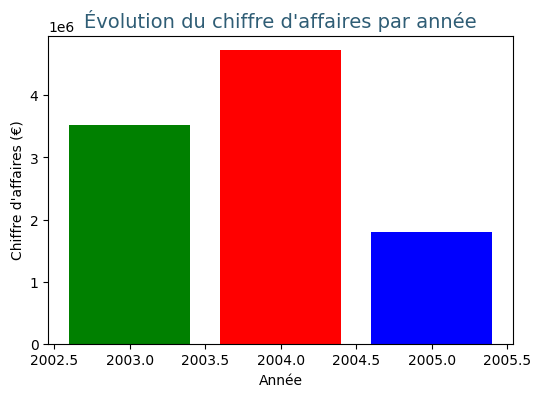

In [42]:
evol_annee = df.groupby("year")["sales"].sum().reset_index()
plt.figure(figsize=(6,4))
plt.bar(evol_annee["year"], evol_annee["sales"], color=["green",'red','blue'])
plt.title("Évolution du chiffre d'affaires par année", color="#2F5D75", fontsize=14)
plt.ylabel("Chiffre d'affaires (€)")
plt.xlabel("Année")
plt.show()


<p style="font-size:23px; color:#B1BAA2; font-weight:bold;"> Chiffre d'affaires par trimestre</p>

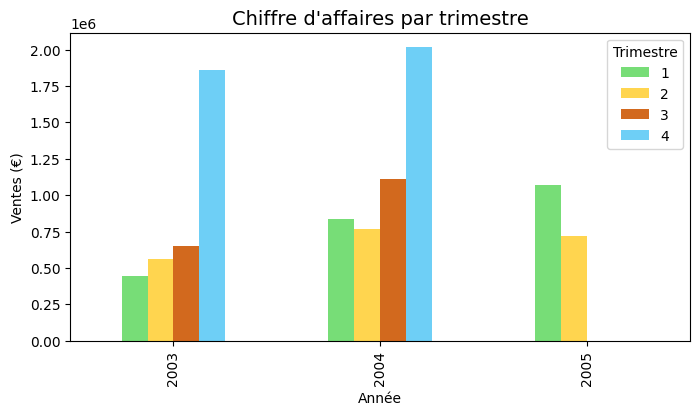

In [43]:
evol_trim = df.groupby(["year", "QTR_ID"])["sales"].sum().unstack()
evol_trim.plot(kind="bar", figsize=(8,4), color=["#77DD77",'#FFD54F','#D2691E','#6ECFF6'])

plt.title("Chiffre d'affaires par trimestre", fontsize=14)
plt.ylabel("Ventes (€)")
plt.xlabel("Année")
plt.legend(title="Trimestre")
plt.show()


<p style="font-size:23px; color:#B1BAA2; font-weight:bold;"> Top 10 pays par chiffres d'affaires </p>

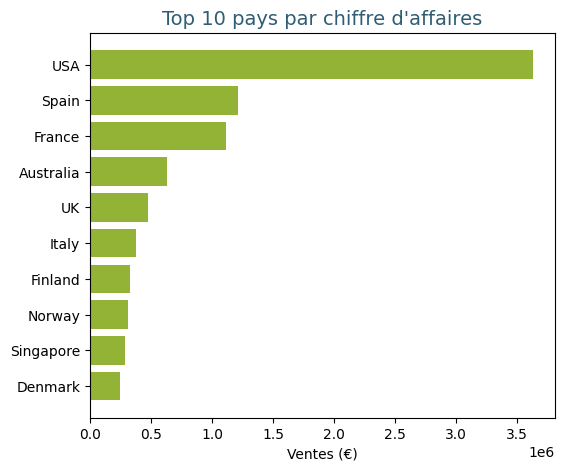

In [44]:
top_pays = df.groupby("country")["sales"].sum().nlargest(10).sort_values().reset_index()

plt.figure(figsize=(6,5))
plt.barh(top_pays["country"], top_pays["sales"], color="#93B336")
plt.title("Top 10 pays par chiffre d'affaires", color="#2F5D75", fontsize=14)
plt.xlabel("Ventes (€)")
plt.show()


<p style="font-size:23px; color:#B1BAA2; font-weight:bold;"> Repartition du CA par categorie (Pie chart) </p>

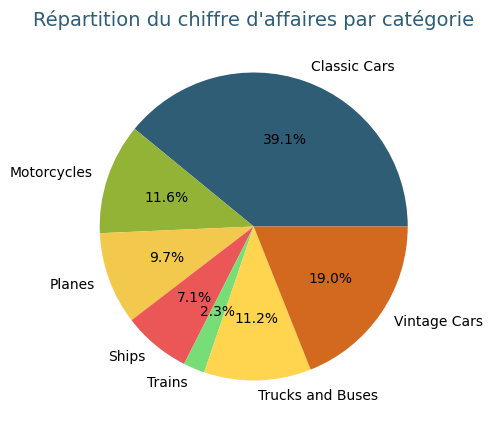

In [45]:
cat = df.groupby("product_category")["sales"].sum()

plt.figure(figsize=(5,5))
plt.pie(cat, labels=cat.index, autopct='%1.1f%%', colors=["#2F5D75","#93B336","#F2C94C","#EB5757","#77DD77",'#FFD54F','#D2691E'])
plt.title("Répartition du chiffre d'affaires par catégorie", color="#2F5D75", fontsize=14)
plt.show()


In [46]:
con.close()